In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt

Calibration

In [5]:
day_count = ql.Actual365Fixed()
calendar  = ql.NullCalendar()

calculation_date = ql.Date(22, 11, 2021)
spot = 57407.27

ql.Settings.instance().evaluationDate = calculation_date

# risk_free_rate = [0.00091249886, 0.00091249886, 0.00141713916, 0.00178991217, 0.00308713517] # 2021/11/02 0D 1D 3M 6M 12M
risk_free_rate = [0.00091249886, 0.00091249886, 0.00141713916, 0.00178991217, 0.00308713517]
risk_free_rate_date = [ql.Date(22, 11, 2021), ql.Date(23, 11, 2021), ql.Date(23, 2, 2022), ql.Date(23, 5, 2022), ql.Date(23, 11, 2022)]
zero_curve_ts = ql.YieldTermStructureHandle(ql.ZeroCurve(risk_free_rate_date, risk_free_rate, day_count, calendar))

dividend_rate = 0.0
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))

In [6]:
# Dummy parameters for construct Heston model
v0 = 0.01; kappa = 0.20; theta = 0.02; rho = -0.75; sigma = 0.50
# v0 = 0.2; kappa = 3.0; theta = 2.0; rho = -0.1; sigma = 4.1
HestonProcess = ql.HestonProcess(zero_curve_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), v0, kappa, theta, sigma, rho)
HestonModel = ql.HestonModel(HestonProcess)
AHE = ql.AnalyticHestonEngine(HestonModel)

In [7]:
# 合約到期日
expiration_dates = [ql.Date(31, 12, 2021), ql.Date(25, 3, 2022), ql.Date(24, 6, 2022)]
# 合約標的
strikes = [30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 120000]
# 合約標的的隱含波動率
data = [[1.1340, 0.9864, 0.8955, 0.8344, 0.8328, 0.8692, 0.9165, 0.9808, 1.0735],
        [1.0149, 0.9587, 0.9241, 0.9046, 0.9000, 0.9055, 0.9177, 0.9338, 0.9684],
        [0.9697, 0.9399, 0.9193, 0.9098, 0.9073, 0.9089, 0.9128, 0.9181, 0.9497]]

# Implied Volatility Matrix
implied_vols = ql.Matrix(len(strikes), len(expiration_dates))
for i in range(implied_vols.rows()):
    for j in range(implied_vols.columns()):
        implied_vols[i][j] = data[j][i]
        
black_var_surface = ql.BlackVarianceSurface(calculation_date, calendar, expiration_dates, strikes, implied_vols, day_count)

In [8]:
heston_helpers = []
black_var_surface.setInterpolation("bicubic")
maturity_idx = 1
date = expiration_dates[maturity_idx]

for j, s in enumerate(strikes):
    t = (date - calculation_date)
    period = ql.Period(t, ql.Days)
    vol = data[maturity_idx][j]
    helper = ql.HestonModelHelper(period, calendar, spot, s, 
                                  ql.QuoteHandle(ql.SimpleQuote(vol)),
                                  zero_curve_ts, 
                                  dividend_ts)
    helper.setPricingEngine(AHE)
    heston_helpers.append(helper)

HestonModel.calibrate(heston_helpers, ql.LevenbergMarquardt(), ql.EndCriteria(500, 50, 1.0e-8, 1.0e-8, 1.0e-8))

theta, kappa, sigma, rho, v0 = HestonModel.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % (theta, kappa, sigma, rho, v0))

theta = 7.586187, kappa = 0.821824, sigma = 3.483438, rho = -0.125186, v0 = 0.007651


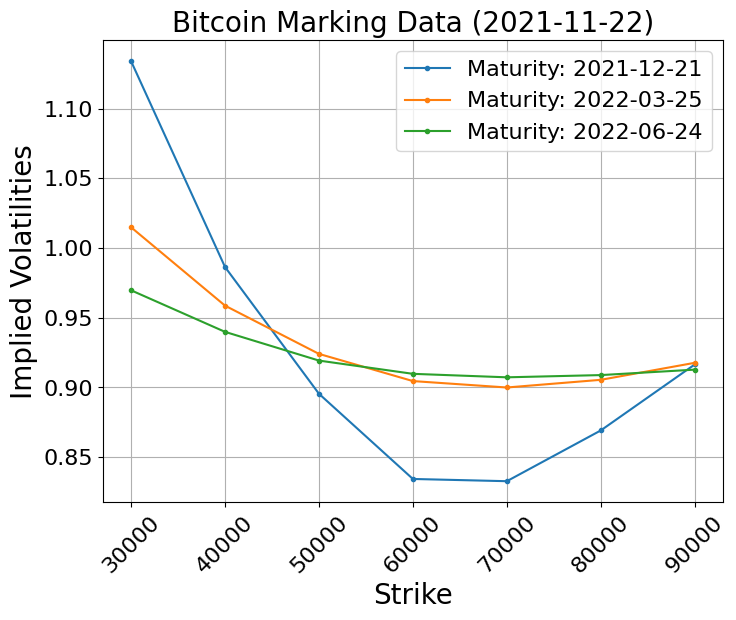

In [20]:
fig = plt.figure(dpi = 100, linewidth = 2)
fig.set_size_inches(8, 6)
    
plt.plot(strikes[0:7], data[0][0:7], '.-', label = "Maturity: 2021-12-21")
plt.plot(strikes[0:7], data[1][0:7], '.-', label = "Maturity: 2022-03-25")
plt.plot(strikes[0:7], data[2][0:7], '.-', label = "Maturity: 2022-06-24")

plt.title("Bitcoin Marking Data (2021-11-22)", fontsize = 20)

plt.xticks(fontsize = 16, rotation = 45)
plt.xlabel("Strike", fontsize = 20)

plt.yticks(fontsize = 16)
plt.ylabel("Implied Volatilities", fontsize = 20)

plt.legend(loc = "best", fontsize = 16)
plt.grid()

plt.show()

In [21]:
HestonProcess = ql.HestonProcess(zero_curve_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), v0, kappa, theta, sigma, rho)
HestonModel = ql.HestonModel(HestonProcess)
AHE = ql.AnalyticHestonEngine(HestonModel)

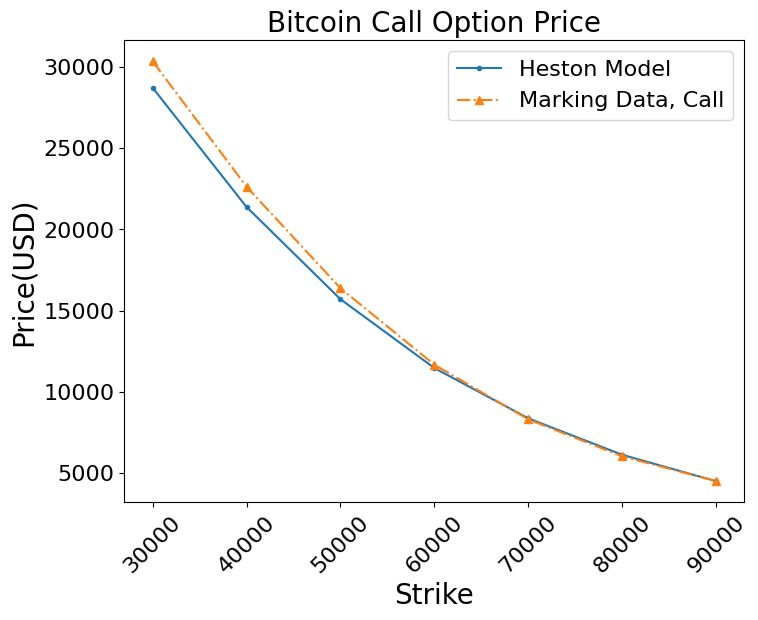

        Strikes    Marking Data    Heston Model    Relative Error(%)
          30000        30349.07         28717.6           -5.38
          40000        22624.92         21379.6            -5.5
          50000        16378.49         15700.7           -4.14
          60000        11668.64         11466.3           -1.73
          70000         8306.99          8370.0            0.76
          80000          6028.6          6126.1            1.62
          90000         4509.68          4503.9           -0.13
Error: 2.75(%)


In [22]:
maturity = ql.Date(25, 3, 2022)

europeanExer = ql.EuropeanExercise(maturity)

bitcoin_strike = [30000, 40000, 50000, 60000, 70000, 80000, 90000]
call = [30349.07, 22624.92, 16378.49, 11668.64, 8306.99, 6028.6, 4509.68]
call_Heston = []

for i in bitcoin_strike:
    vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Call, i)
    anEuroOption = ql.EuropeanOption(vanillaPayoff, europeanExer)
    anEuroOption.setPricingEngine(AHE)
    call_Heston.append(anEuroOption.NPV())

fig = plt.figure(dpi = 100, linewidth = 2)
fig.set_size_inches(8, 6)
    
plt.plot(range(len(bitcoin_strike)), call_Heston, '.-', label = "Heston Model")
plt.plot(range(len(bitcoin_strike)), call, '^-.', label = "Marking Data, Call")

plt.title("Bitcoin Call Option Price", fontsize = 20)

xticks_number = []
xticks_name = []
for i in range(len(bitcoin_strike)):
    xticks_number.append(i)
    xticks_name.append(bitcoin_strike[i])
plt.xticks(xticks_number, xticks_name, fontsize = 16, rotation = 45)
plt.xlabel("Strike", fontsize = 20)

plt.yticks(fontsize = 16)
plt.ylabel("Price(USD)", fontsize = 20)

plt.legend(loc = "best", fontsize = 16)

plt.show()

avg = 0.0
print("%15s %15s %15s %20s" % ("Strikes", "Marking Data", "Heston Model", "Relative Error(%)"))
print("="*100)
for i in range(len(bitcoin_strike)):
    err = (call_Heston[i]/call[i] - 1.0)
    print("%15s %15s %15s %15s" % (bitcoin_strike[i], call[i], round(call_Heston[i],1), round(100.0*err, 2)))
    avg += abs(err)*100/len(bitcoin_strike)
print("="*100)
print("Error: " + str(round(avg, 2)) + '(%)')

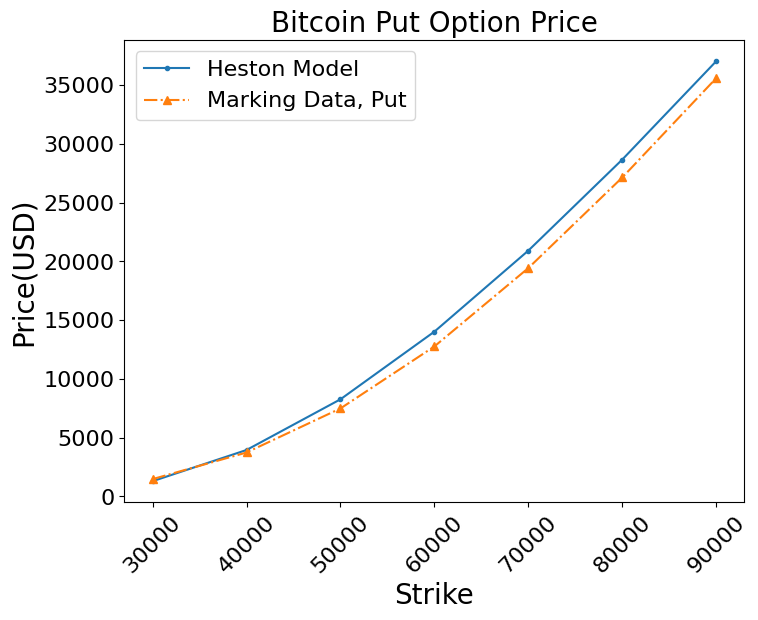

        Strikes    Marking Data    Heston Model    Relative Error(%)
          30000         1471.83          1294.8          -12.03
          40000         3738.44          3951.5             5.7
          50000         7488.66          8267.4            10.4
          60000        12769.57         14027.9            9.85
          70000        19439.89         20926.4            7.65
          80000        27152.26         28677.2            5.62
          90000        35606.44         37049.8            4.05
Error: 7.9(%)


In [23]:
maturity = ql.Date(25, 3, 2022)

europeanExer = ql.EuropeanExercise(maturity)

bitcoin_strike = [30000, 40000, 50000, 60000, 70000, 80000, 90000]
put = [1471.83, 3738.44, 7488.66, 12769.57, 19439.89, 27152.26, 35606.44]
put_Heston = []

for i in bitcoin_strike:
    vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Put, i)
    anEuroOption = ql.EuropeanOption(vanillaPayoff, europeanExer)
    anEuroOption.setPricingEngine(AHE)
    put_Heston.append(anEuroOption.NPV())

fig = plt.figure(dpi = 100, linewidth = 2)
fig.set_size_inches(8, 6)
    
plt.plot(range(len(bitcoin_strike)), put_Heston, '.-', label = "Heston Model")
plt.plot(range(len(bitcoin_strike)), put, '^-.', label = "Marking Data, Put")

plt.title("Bitcoin Put Option Price", fontsize = 20)

xticks_number = []
xticks_name = []
for i in range(len(bitcoin_strike)):
    xticks_number.append(i)
    xticks_name.append(bitcoin_strike[i])
plt.xticks(xticks_number, xticks_name, fontsize = 16, rotation = 45)
plt.xlabel("Strike", fontsize = 20)

plt.yticks(fontsize = 16)
plt.ylabel("Price(USD)", fontsize = 20)

plt.legend(loc = "best", fontsize = 16)

plt.show()

avg = 0.0
print("%15s %15s %15s %20s" % ("Strikes", "Marking Data", "Heston Model", "Relative Error(%)"))
print("="*100)
for i in range(len(bitcoin_strike)):
    err = (put_Heston[i]/put[i] - 1.0)
    print("%15s %15s %15s %15s" % (bitcoin_strike[i], put[i], round(put_Heston[i],1), round(100.0*err, 2)))
    avg += abs(err)*100/len(bitcoin_strike)
print("="*100)
print("Error: " + str(round(avg, 2)) + '(%)')

Heston Model 退化

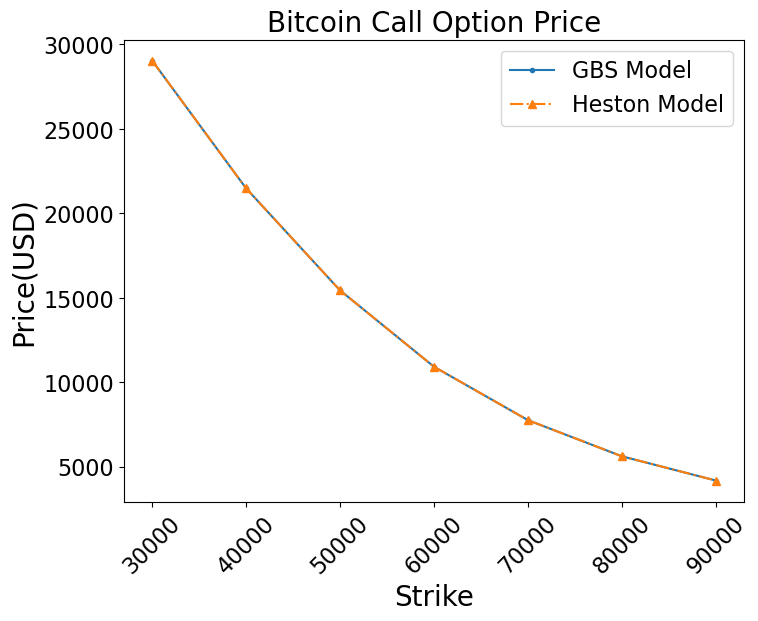

In [10]:
maturity = ql.Date(25, 3, 2022)
bitcoin_strike = [30000, 40000, 50000, 60000, 70000, 80000, 90000]
europeanExer = ql.EuropeanExercise(maturity)
Call_GBS = []
Call_Heston = []

for i in bitcoin_strike:
    
    expiry = (date - calculation_date)/365 # years
    vol = black_var_surface.blackVol(expiry, i)
    HestonProcess = ql.HestonProcess(zero_curve_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), vol**2, 2E-5, theta, 2E-5, 2E-5) # 參數最低不能小於等於1E-5，否則NPV為Nan v0, kappa, theta, sigma, rho
    HestonModel = ql.HestonModel(HestonProcess)
    AHE = ql.AnalyticHestonEngine(HestonModel)

    black_var_surface_handel = ql.BlackVolTermStructureHandle(black_var_surface)
    GBSProcess = ql.GeneralizedBlackScholesProcess(ql.QuoteHandle(ql.SimpleQuote(spot)), dividend_ts, zero_curve_ts, black_var_surface_handel)
    AEE = ql.AnalyticEuropeanEngine(GBSProcess)
    
    vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Call, i)

    anEuroOption_Heston = ql.EuropeanOption(vanillaPayoff, europeanExer)
    anEuroOption_GBS = ql.EuropeanOption(vanillaPayoff, europeanExer)

    anEuroOption_GBS.setPricingEngine(AEE)
    Call_GBS.append(anEuroOption_GBS.NPV())
    anEuroOption_Heston.setPricingEngine(AHE)
    Call_Heston.append(anEuroOption_Heston.NPV())

fig = plt.figure(dpi = 100, linewidth = 2)
fig.set_size_inches(8, 6)
    
plt.plot(range(len(bitcoin_strike)), Call_GBS, '.-', label = "GBS Model")
plt.plot(range(len(bitcoin_strike)), Call_Heston, '^-.', label = "Heston Model")

plt.title("Bitcoin Call Option Price", fontsize = 20)

xticks_number = []
xticks_name = []
for i in range(len(bitcoin_strike)):
    xticks_number.append(i)
    xticks_name.append(bitcoin_strike[i])
plt.xticks(xticks_number, xticks_name, fontsize = 16, rotation = 45)
plt.xlabel("Strike", fontsize = 20)

plt.yticks(fontsize = 16)
plt.ylabel("Price(USD)", fontsize = 20)

plt.legend(loc = "best", fontsize = 16)

plt.show()

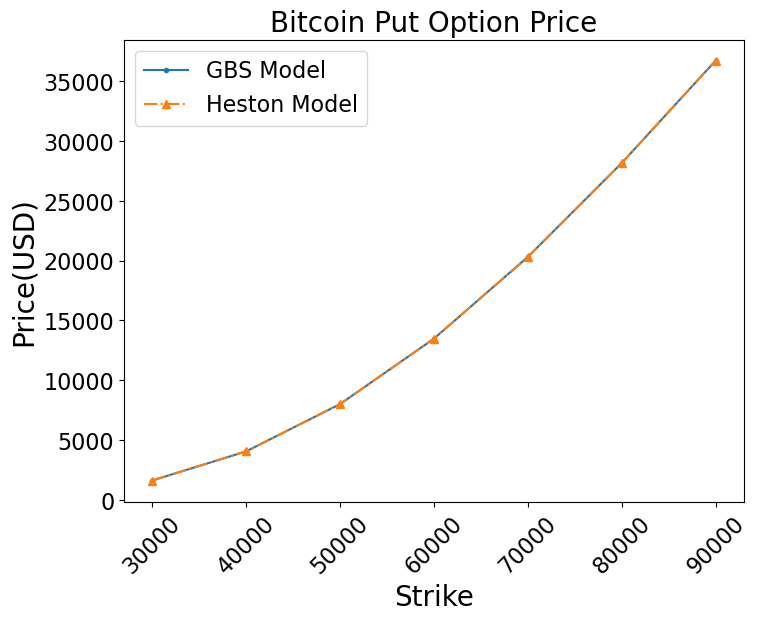

In [11]:
maturity = ql.Date(25, 3, 2022)
bitcoin_strike = [30000, 40000, 50000, 60000, 70000, 80000, 90000]
europeanExer = ql.EuropeanExercise(maturity)
Put_GBS = []
Put_Heston = []

for i in bitcoin_strike:
    
    expiry = (date - calculation_date)/365 # years
    vol = black_var_surface.blackVol(expiry, i)
    HestonProcess = ql.HestonProcess(zero_curve_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), vol**2, 2E-5, theta, 2E-5, 2E-5) # 參數最低不能小於等於1E-5，否則NPV為Nan v0, kappa, theta, sigma, rho
    HestonModel = ql.HestonModel(HestonProcess)
    AHE = ql.AnalyticHestonEngine(HestonModel)

    black_var_surface_handel = ql.BlackVolTermStructureHandle(black_var_surface)
    GBSProcess = ql.GeneralizedBlackScholesProcess(ql.QuoteHandle(ql.SimpleQuote(spot)), dividend_ts, zero_curve_ts, black_var_surface_handel)
    AEE = ql.AnalyticEuropeanEngine(GBSProcess)
    
    vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Put, i)

    anEuroOption_Heston = ql.EuropeanOption(vanillaPayoff, europeanExer)
    anEuroOption_GBS = ql.EuropeanOption(vanillaPayoff, europeanExer)

    anEuroOption_GBS.setPricingEngine(AEE)
    Put_GBS.append(anEuroOption_GBS.NPV())
    anEuroOption_Heston.setPricingEngine(AHE)
    Put_Heston.append(anEuroOption_Heston.NPV())

fig = plt.figure(dpi = 100, linewidth = 2)
fig.set_size_inches(8, 6)
    
plt.plot(range(len(bitcoin_strike)), Put_GBS, '.-', label = "GBS Model")
plt.plot(range(len(bitcoin_strike)), Put_Heston, '^-.', label = "Heston Model")

plt.title("Bitcoin Put Option Price", fontsize = 20)

xticks_number = []
xticks_name = []
for i in range(len(bitcoin_strike)):
    xticks_number.append(i)
    xticks_name.append(bitcoin_strike[i])
plt.xticks(xticks_number, xticks_name, fontsize = 16, rotation = 45)
plt.xlabel("Strike", fontsize = 20)

plt.yticks(fontsize = 16)
plt.ylabel("Price(USD)", fontsize = 20)

plt.legend(loc = "best", fontsize = 16)

plt.show()